# PatchSim

In [1]:
# Importando librerías
import pandas as pd
import patchsim as sim
import numpy as np
import matplotlib.pyplot as plt

## Parámetros

In [2]:
# Parámetros
N = 5549758         # Total de la población
R0 = 2.68           # R0
alpha = 1/7         # Tasa de infección (tiempo promedio de incubación)
gamma = 1/4.8       # Tasa de recuperación (periodo infeccioso medio)
beta = (R0*gamma)/N # Tasa de expuestos: la probabilidad de que un susceptible se infecte.
T = 400             # Simulación de dias

#-----------------------------------------------------------------------------------------
# Print resultados
print("beta =",np.round(beta,10), ">> Tasa de expuestos", 
      "\nalpha =",np.round(alpha,3), ">> Tasa de infección",
      "\ngamma = ",np.round(gamma,3), ">> Tasa de recuperación")

beta = 1.006e-07 >> Tasa de expuestos 
alpha = 0.143 >> Tasa de infección 
gamma =  0.208 >> Tasa de recuperación


## Configuraciones

In [3]:
# cfg.txt: Archivo de configuraciones
#-----------------------------------------------------------------------------------------
f = open("files/cfg.txt", "w")
f.write("""
PatchFile=files/pop.txt
NetworkFile=files/net.txt
NetworkType=Static
SeedFile=files/seeds.txt
ParamFile=files/parametros.txt

ExposureRate=1.006e-07
InfectionRate=0.143
RecoveryRate=0.208
ScalingFactor=0.0625

StartDate=1
Duration=400

LoadState=False
SaveState=False

OutputFile=resultados.out
OutputFormat=Whole
LogFile=proceso.log
""")
f.close()

## Poblaciones y modificación de $\beta$ según el tamaño de cada población 

$$ \beta = \frac{R_0\gamma}{N} $$

In [4]:
# pop.txt: Archivo que contiene las poblaciones
#-----------------------------------------------------------------------------------------
localidades = pd.read_csv("files/info_local_2020.csv")
df = pd.DataFrame( {"id_localidades":localidades["local_id"].values, 
                        "poblacion":localidades["PopCDR"].values})
df.to_csv("files/pop.txt", header = False, index = False, sep=' ')
#-----------------------------------------------------------------------------------------
# ParamFiles: parametros.txt - Contiene los betas para cada poblacion y tiempo.
#-----------------------------------------------------------------------------------------
#Betas para cada poblacion
df1 = pd.DataFrame([[R0*gamma/i]*T for i in df["poblacion"]], index=df["id_localidades"])
df1.to_csv("files/parametros.txt", header = False, index = True, sep=' ')
#-----------------------------------------------------------------------------------------
N=df["poblacion"].sum()  # Cantidad de personas
print("Total poblacion =",N) 
df.T

Total poblacion = 5549758


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
id_localidades,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
poblacion,369936,152168,93928,257646,230318,124375,458427,730237,272242,617260,865749,169295,117041,73041,76972,158021,19142,265916,498044


## Conexiones net.txt

In [5]:
# Conexiones: net.txt - Contiene las conectividades de viajes entre cada poblacion 19x19
#-----------------------------------------------------------------------------------------
redes = pd.read_csv("files/cdr_od_loc.csv")

df = pd.DataFrame( {"origen":redes["o_loc"].values, 
                    "destino":redes["d_loc"].values, 
                    "dia":np.zeros(len(redes), dtype=int),
                    "hbw":redes["hbw"].values})

df.to_csv("files/net.txt", header = False, index = False, sep=' ')
df.T.round(1)

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
origen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0
destino,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
dia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hbw,247173.6,36749.4,4919.9,17711.7,13177.1,3800.7,18947.2,15692.6,7037.5,15783.7,...,14972.8,10242.9,9503.4,4900.9,1597.7,1984.6,4673.5,381.0,9756.3,63926.8


## Semillas seeds.txt

In [6]:
# Semillas: seeds.txt - Contiene los infectados iniciales durante los primeros 7 dias de la pandemia de cada localidad
#---------------------------------------------------------------------------------------------------------------------
casos = pd.read_csv("files/osb_enftransm-covid-19_17042021.csv", nrows=732872, encoding='latin-1', delimiter=";")
# Renombrando columnas
casos = casos.rename(columns={"LOCALIDAD_ASIS": 'Localidad',
                             "FECHA_DIAGNOSTICO":'fecha'})
# Convirtiendo en formato fecha de pandas
casos["fecha"] = pd.to_datetime(casos["fecha"], format="%d/%m/%Y")  # to DateTime
dia1 = casos["fecha"].min()  # Primer caso de covid en Bogotá  # 6 de marzo de 2020

# Calculando el tiempo transcurrido en dias
tiempo = casos["fecha"] - dia1 # Tiempo transcurrido
casos["dia"] = tiempo.dt.days # To int.

# Uniendo base de datos localidades y número de casos
datos = pd.merge(casos, localidades, on='Localidad')  # Uniendo datos by id: "localidades".
Ncasos = datos.groupby(['dia', 'local_id']).size().reset_index(name='# Casos')  # Cantidad de casos

# Semillas: Cantidad de infectados en los primeros 7 dias para cada localidad.
df = Ncasos[Ncasos["dia"]<=7]    
df.to_csv("files/seeds.txt", header = False, index = False, sep=' ')
df.T

,0,1,2,3,4,5,6,7
dia,0,4,6,6,7,7,7,7
local_id,1,10,8,9,2,10,11,13
# Casos,1,2,1,1,1,3,1,1


## Llamando la función PatchSim

In [7]:
# Ejecutando función PatchSim
#---------------------------------------------------------------------------------------------------------------------
configs = sim.read_config('files/cfg.txt')
sim.run_disease_simulation(configs, write_epi=True)

245920

## Gráficos reales vs simulaciones

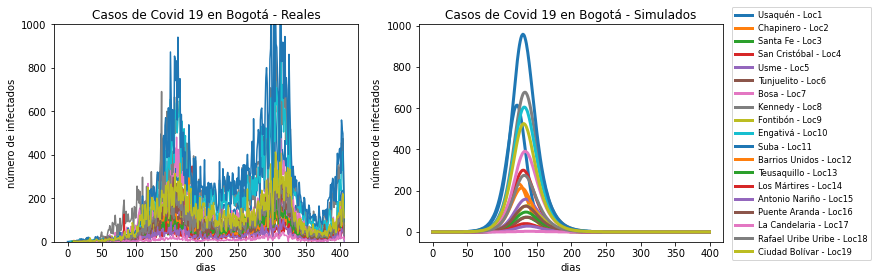

In [12]:
infec = np.loadtxt("resultados.out")
infec = pd.DataFrame(infec, index=infec.T[0]).drop(0, axis=1)
infec = infec.sort_index()
# Graficos
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(12,4))
for i in localidades["local_id"].values:
    # Casos reales
    loc = Ncasos[Ncasos["local_id"]==i] # Localidad i
    tiempo = loc["dia"].values
    casos = loc["# Casos"].values
    ax1.plot(tiempo, casos, label="Reales")
    # Casos simulaciones
    infectados = infec.T[i]
    t = np.arange(0, len(infectados))
    ax2.plot(t, infectados, lw=3, label=str(localidades["Localidad"][i-1]) + " - Loc"+str(i))
    ax2.legend(loc="right", bbox_to_anchor=(1.5,0.5), fontsize=8.3)
    # Propiedades gráficas
    ax1.set_title("Casos de Covid 19 en Bogotá - Reales")
    ax2.set_title("Casos de Covid 19 en Bogotá - Simulados")
    ax1.set_xlabel("dias")
    ax2.set_xlabel("dias")
    ax1.set_ylabel("número de infectados")
    ax2.set_ylabel("número de infectados")
    ax1.set_ylim([0,1000])

## Gráficos reales vs simulaciones individules

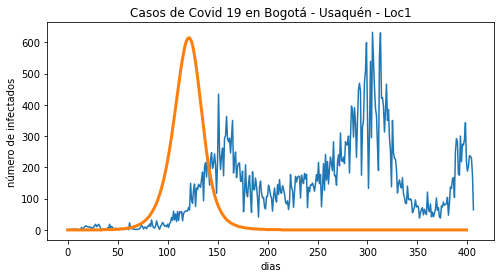

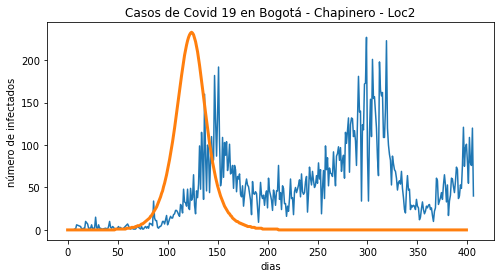

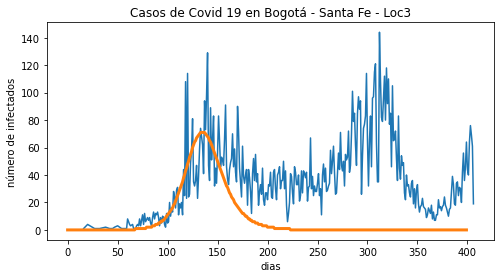

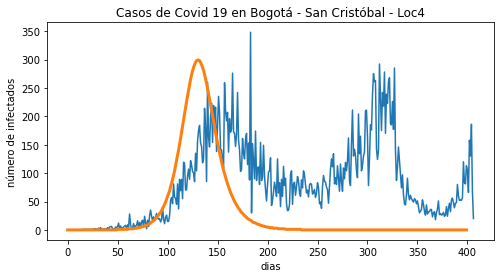

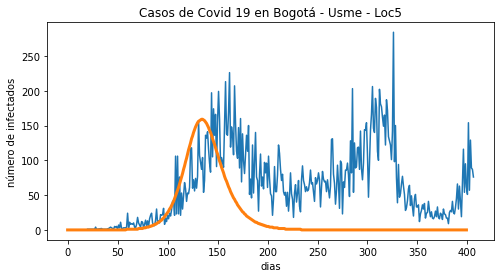

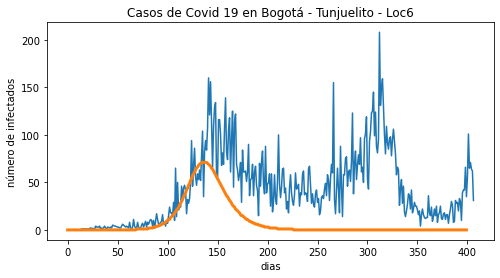

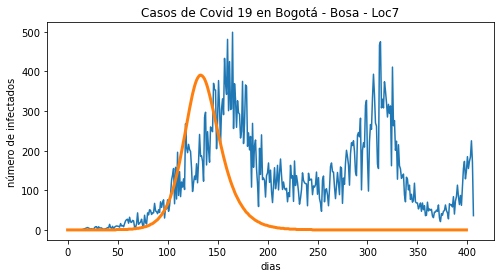

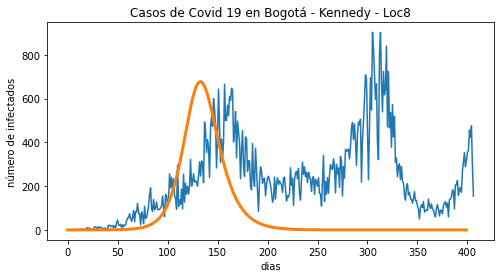

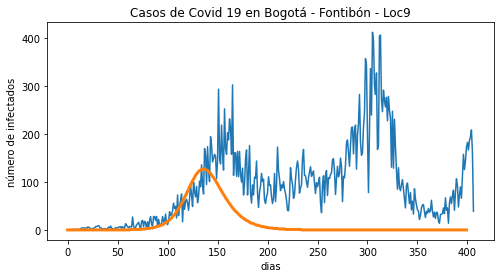

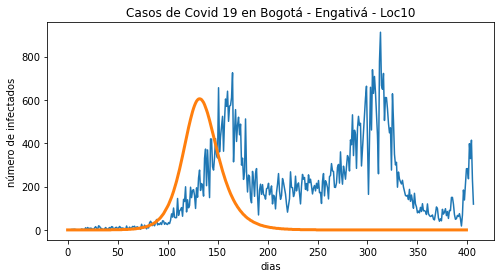

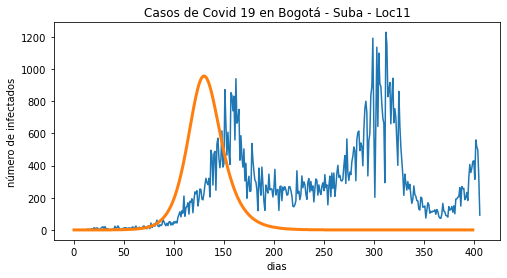

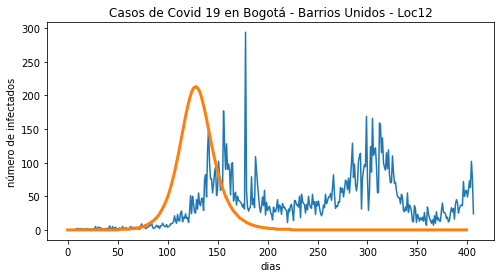

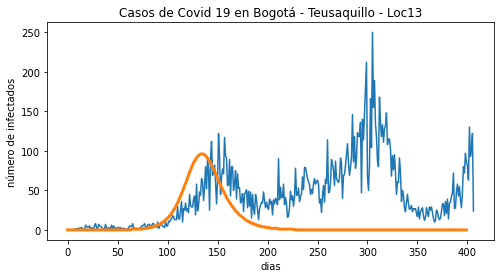

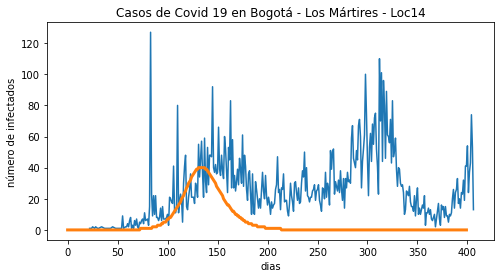

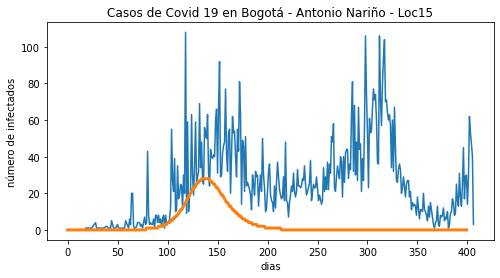

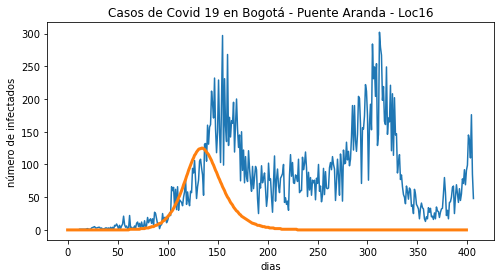

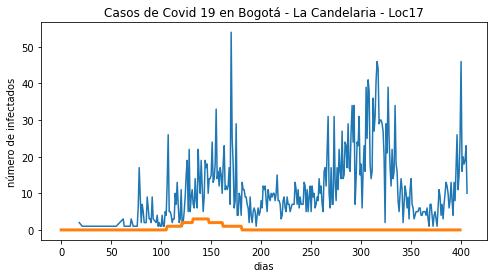

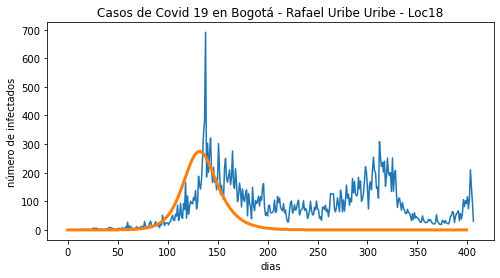

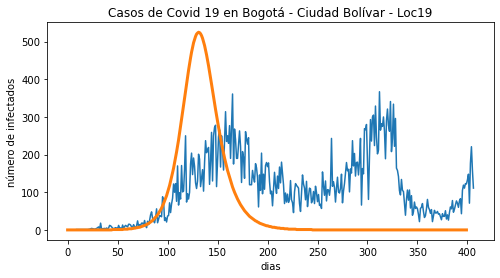

In [9]:
# Graficos
for i in localidades["local_id"].values:
    fig, ax1 = plt.subplots(figsize=(8,4))
    # Casos reales
    loc = Ncasos[Ncasos["local_id"]==i] # Localidad i
    tiempo = loc["dia"].values
    casos = loc["# Casos"].values
    ax1.plot(tiempo, casos, label="Reales")
    # Casos simulaciones
    infectados = infec.T[i]
    t = np.arange(0, len(infectados))
    ax1.plot(t, infectados, label="Simulaciones", lw=3)
    # Propiedades gráficas
    ax1.set_xlabel("dias")
    ax1.set_title("Casos de Covid 19 en Bogotá - "+str(localidades["Localidad"][i-1]) + " - Loc"+str(i))
    ax1.set_ylabel("número de infectados")

## Referencias

+ Análisis del Covid-19 por medio de un modelo SEIR  
    https://institucional.us.es/blogimus/2020/03/covid-19-analisis-por-medio-de-un-modelo-seir/
      
+ Modelo SEIR para Colombia: Medidas de mitigación del virus  
    https://www.eafit.edu.co/escuelas/economiayfinanzas/cief/Documents/informe-especial-2020-abril-2.pdf
      
+ shinySIR: Interactive plotting for infectious disease models  
    https://cran.r-project.org/web/packages/shinySIR/vignettes/Vignette.html